In [1]:
# Libraries importation

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Seaborn for heatmaps
import seaborn as sns

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

import statistics

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
# get latitute and longitude of Grenoble
address = 'Grenoble'
geolocator = Nominatim(user_agent="grenoble_explorer")
location = geolocator.geocode(address)
gre_latitude = location.latitude
gre_longitude = location.longitude
print('The geographical coordinates of Grenoble are {}, {}.'.format(gre_latitude, gre_longitude))

The geographical coordinates of Grenoble are 45.1875602, 5.7357819.


In [3]:
# Define Foursquare credentials and version
CLIENT_ID = 'JGPVB4QLBTTZ10Z1P4MELBGQUT4HW2AXGIJLKNJR5U5NPCWF'
CLIENT_SECRET = 'XFKC1NP1NK0QZC5PZJDIP215JZAQ1LTBSJTXQCCUWIJ5BH2T'
VERSION = '20190117' # Foursquare API version

In [7]:
# Get the top 100 venues in Grenoble within a radius of 3000 meters
limit = 100 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    gre_latitude, 
    gre_longitude, 
    radius, 
    limit)
results = requests.get(url).json()

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
# Put the venues in a dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Jardin du thé,Tea Room,45.188788,5.727536
1,Place Victor Hugo,Plaza,45.188994,5.724607
2,L'Ardoise,French Restaurant,45.190558,5.725346
3,Okko Hotels Grenoble Jardin Hoche,Resort,45.184859,5.726299
4,Le Café Curieux,Bistro,45.186792,5.723978


In [35]:
# create map of Grenoble using latitude and longitude values
map_grenoble = folium.Map(location=[gre_latitude, gre_longitude], zoom_start=14)

# add markers for venues to the map
for lat, lng, name, categories in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_grenoble)  
    
map_grenoble

In [12]:
#DBSCAN density-based clustering of Grenoble's venues
epsilon = 0.001
minimumSamples = 2
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(nearby_venues[['lat','lng']])
labels = db.labels_
labels

array([-1, -1, -1,  0,  1,  2,  3, -1,  1, -1, -1,  4, -1, -1,  2, -1,  4,
       -1,  5,  6,  5,  3,  7,  5,  8,  2, -1,  5,  5,  9, 10, -1,  3,  0,
       -1,  3,  3, 10,  3,  3,  9,  3,  3,  5, 11,  8, -1, 12, -1, -1, -1,
        5, -1, 12, -1, -1, 13, 13, 11, -1, 14, -1, -1, -1,  6,  7, -1, -1,
       15, 15, -1, -1, -1, 14, -1, -1, -1, -1, -1, -1])

In [33]:
# separate clusters from outliers
nearby_venues['cluster']=labels
nearby_venues_clustered=nearby_venues[nearby_venues['cluster']!=(-1)] # remove outliers
nearby_venues_outliers=nearby_venues[nearby_venues['cluster']==(-1)]

# create map
map_clusters = folium.Map(location=[gre_latitude, gre_longitude], zoom_start=14)

# set color scheme for the clusters
kclusters=len(np.unique(labels))-1
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i*0.7) for i in colors_array]

# add clusters markers to the map (color circles)
for lat, lng, name, cluster in zip(nearby_venues_clustered['lat'], nearby_venues_clustered['lng'], nearby_venues_clustered['name'], nearby_venues_clustered['cluster']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# add outliers markers to the map (black dots)
for lat, lng, name, cluster in zip(nearby_venues_outliers['lat'], nearby_venues_outliers['lng'], nearby_venues_outliers['name'], nearby_venues_outliers['cluster']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=1).add_to(map_clusters)    
    

map_clusters

In [21]:
# Get car parks data in a dataframe
parkings=pd.read_csv('http://data.metromobilite.fr/api/findType/csv?types=PKG')
parkings.head()

,CODE,LIBELLE,ADRESSE,TYPE,TOTAL,type,id,COMMUNE,LIGNES,LaMetro,LeGresivaudan,PaysVoironnais,lon,lat
0,EFF_PKG_ESTACADE,ESTACADE,RUE DENFERT ROCHEREAU,PKG,581,PKG,EFF_PKG_ESTACADE,Grenoble,"SEM_A,SEM_B",True,False,False,5.716033,45.188780
1,EFF_PKG_EUROPOLE,GARES - EUROPOLE,"2, AVENUE DOYEN LOUIS WEIL",PKG,1051,PKG,EFF_PKG_EUROPOLE,Grenoble,"SEM_B,SEM_C5",True,False,False,5.712008,45.191959
2,EFF_PKG_VICTOR_HUGO,VICTOR HUGO,RUE FRANÇOIS RAOULT,PKG,660,PKG,EFF_PKG_VICTOR_HUGO,Grenoble,SEM_16,True,False,False,5.726327,45.185748
3,EFF_PKG_LAFAYETTE,LAFAYETTE,RUE RAOUL BLANCHARD,PKG,285,PKG,EFF_PKG_LAFAYETTE,Grenoble,"SEM_A,SEM_B",True,False,False,5.729321,45.190778
4,EFF_PKG_MUSEE,NOTRE DAME - MUSÉE,"50, AVENUE MARÉCHAL RANDON",PKG,851,PKG,EFF_PKG_MUSEE,Grenoble,"SEM_B,SEM_16,SEM_62",True,False,False,5.732239,45.194399


In [34]:
# add car parks markers to the map
for lat, lon, libelle in zip(parkings['lat'], parkings['lon'], parkings['LIBELLE']):
    label = folium.Popup(str(libelle), parse_html=True)
    folium.Marker(
        [lat, lon],
        popup=label,
        icon=folium.Icon(color='red', icon='car', prefix='fa')).add_to(map_clusters)
       
map_clusters


In [24]:
# Computation of distances from venues to car parks

# Initialize distance matrix with empty lists
df_distance=pd.DataFrame(columns=np.unique(labels),index=parkings['LIBELLE'])
for i in df_distance.index:
    for j in df_distance.columns:
        df_distance.loc[i,j]=[]

# Computation of distance matrix
# Row=parking, column=cluster, cell=list of distances from all venues of cluster to parking
for p in df_distance.index:
    for c in df_distance.columns:
        for v in range(len(nearby_venues_clustered[nearby_venues_clustered['cluster']==c].index)):
            x1=nearby_venues_clustered[nearby_venues_clustered['cluster']==c][['lat','lng']].iloc[v,0]
            y1=nearby_venues_clustered[nearby_venues_clustered['cluster']==c][['lat','lng']].iloc[v,1]
            x2=parkings[parkings['LIBELLE']==p][['lat','lon']].iloc[0,0]
            y2=parkings[parkings['LIBELLE']==p][['lat','lon']].iloc[0,1]
            df_distance.loc[p,c].append(float(euclidean_distances([[x1,y1]],[[x2,y2]])))
df_distance=df_distance.drop([-1],axis=1) # Remove outliers cluster
df_distance.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
LIBELLE,,,,,,,,,,,,,,,,
ESTACADE,"[0.010988811909196714, 0.010256769090738317]","[0.008190057029457626, 0.00821529824562055]","[0.01182214704948849, 0.012701893328585687, 0....","[0.014684040527354189, 0.016051330807739503, 0...","[0.006520639781295689, 0.007292746094546028]","[0.014341016905084372, 0.014420527234346062, 0...","[0.01346898389323011, 0.013444635506598395]","[0.01622458509675507, 0.01648924008626415]","[0.009917548735096024, 0.009577003327501155]","[0.01778256394131665, 0.01738816333221619]","[0.011297766013876808, 0.010852911727476156]","[0.017405443103614478, 0.01720210540527819]","[0.011771625198891886, 0.011286458534609602]","[0.007168620034282043, 0.006521265141914875]","[0.016994780774284627, 0.01613637314492005]","[0.022047722594198287, 0.022485731252530592]"
GARES - EUROPOLE,"[0.01595701498417506, 0.01528398021329736]","[0.013037646612879865, 0.01303861434517998]","[0.01565691119585124, 0.01661369796391712, 0.0...","[0.01854080049910506, 0.019571259534978076, 0....","[0.011622396536212594, 0.012369489922641672]","[0.01787571303105927, 0.01795448167238767, 0.0...","[0.014782981805916784, 0.014764559589073344]","[0.019372364641537267, 0.01957952679192465]","[0.015037493573233128, 0.014677752387424362]","[0.020270962841538346, 0.020002841454995403]","[0.014131612969985318, 0.013777820463173277]","[0.020650031576942375, 0.0204522976455799]","[0.009062724979932915, 0.00830173089817745]","[0.007780660196714921, 0.007476103120665608]","[0.012029548312402038, 0.011172851258826808]","[0.024946368472044105, 0.025398943025641798]"
VICTOR HUGO,"[0.0008891416155753296, 0.0015209362324787783]","[0.00257050064217306, 0.0025761912001632573]","[0.0054488478551531876, 0.005499529585897249, ...","[0.006819070629408433, 0.008823957819029251, 0...","[0.0046779541637528566, 0.003848416964458193]","[0.007655480106434847, 0.007705278816522848, 0...","[0.012966402190520787, 0.012940599585016461]","[0.010032917198741484, 0.010379179138596706]","[0.0032762298221189184, 0.0027968484250367343]","[0.012911163007842539, 0.012300111646762119]","[0.008420698825462078, 0.008060760532888744]","[0.010612330724354635, 0.010444568272581157]","[0.021976727170217016, 0.021647907200896526]","[0.012003262751433545, 0.011472335375145654]","[0.026574120212662485, 0.0257435797000455]","[0.015286845668970055, 0.01562827215028126]"
LAFAYETTE,"[0.006645740356982084, 0.007363580507160417]","[0.006665675849305872, 0.006538287412896047]","[0.0017030547347651076, 0.0007423400511354474,...","[0.001255626053944763, 0.0030522353573527003, ...","[0.009317354413987396, 0.00869131042475026]","[0.0018391815033073045, 0.0018783253007405244,...","[0.008905571336415915, 0.008885422860362147]","[0.004184967071274111, 0.004531058076285368]","[0.009105636077574593, 0.008567025767816205]","[0.007142112003132904, 0.006518662814898174]","[0.004763822483671288, 0.004731727369080386]","[0.004806557675989585, 0.004628168978970029]","[0.02520898545800799, 0.024709440426494037]","[0.011225394466867206, 0.010991986666894259]","[0.026542590623104573, 0.02578132924237669]","[0.009587189290522245, 0.009960482007106227]"
NOTRE DAME - MUSÉE,"[0.011238068726585922, 0.011995607723742445]","[0.011229538320205507, 0.01109501101084856]","[0.005698748087748, 0.005157548602985889, 0.00...","[0.0036995423134355988, 0.0016884094763119457,...","[0.013839745781103637, 0.013265070794577637]","[0.003012764712349483, 0.002942257834370636, 0...","[0.00824472232399932, 0.008237178057925123]","[0.0010337064158688295, 0.0009562403013748331]","[0.01374442419192611, 0.013214307141009496]","[0.0032747271537391814, 0.0027075908916883874]","[0.006276513960199868, 0.006603186354805233]","[0.00027974943315546867, 0.0001335212160825123]","[0.0288029475745057, 0.028221390751469993]","[0.013227839883958058, 0.013231739825500929]","[0.02804223100422544, 0.027355649954229528]","[0.005037141448356001, 0.005443914993492652]"


In [25]:
# Computation of distances from clusters of venues to car parks with 3 different metrics

# Matrix of mean distances
df_mean_distance=df_distance.applymap(statistics.mean)

#Matrix of max distances
df_max_distance=df_distance.applymap(max)

#Matrix of min distances
df_min_distance=df_distance.applymap(min)
df_min_distance.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
LIBELLE,,,,,,,,,,,,,,,,
ESTACADE,0.010257,0.008190,0.011503,0.014684,0.006521,0.014029,0.013445,0.016225,0.009577,0.017388,0.010853,0.017202,0.011286,0.006521,0.016136,0.022048
GARES - EUROPOLE,0.015284,0.013038,0.015401,0.018541,0.011622,0.017244,0.014765,0.019372,0.014678,0.020003,0.013778,0.020452,0.008302,0.007476,0.011173,0.024946
VICTOR HUGO,0.000889,0.002571,0.005126,0.006734,0.003848,0.007655,0.012941,0.010033,0.002797,0.012300,0.008061,0.010445,0.021648,0.011472,0.025744,0.015287
LAFAYETTE,0.006646,0.006538,0.000742,0.001256,0.008691,0.001839,0.008885,0.004185,0.008567,0.006519,0.004732,0.004628,0.024709,0.010992,0.025781,0.009587
NOTRE DAME - MUSÉE,0.011238,0.011095,0.005158,0.001232,0.013265,0.002942,0.008237,0.000956,0.013214,0.002708,0.006277,0.000134,0.028221,0.013228,0.027356,0.005037


6     0.006816
12    0.006445
13    0.005454
15    0.005241
14    0.005161
4     0.004263
8     0.003037
9     0.002991
1     0.002573
3     0.002378
5     0.002281
10    0.002216
2     0.001468
0     0.001205
7     0.000995
11    0.000207
dtype: float64


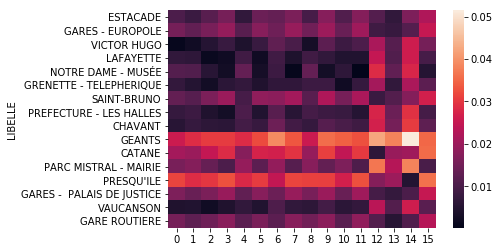

In [28]:
# Sort clusters by descending mean distance to the nearest car park
print(df_mean_distance.min().sort_values(ascending=False))

# Visualization of mean distances from clusters to car parks
heatmap_mean = sns.heatmap(df_mean_distance)

6     0.006803
12    0.006051
13    0.005400
15    0.005037
14    0.004752
4     0.003848
8     0.002797
9     0.002708
1     0.002571
10    0.001993
5     0.001839
3     0.001232
7     0.000956
0     0.000889
2     0.000742
11    0.000134
dtype: float64


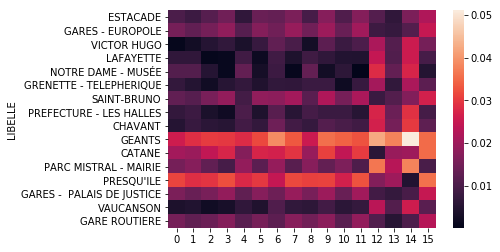

In [29]:
# Sort clusters by descending min distance to the nearest car park
print(df_min_distance.min().sort_values(ascending=False))

# Visualization of min distances from clusters to car parks
heatmap_min = sns.heatmap(df_min_distance)

12    0.006839
6     0.006829
14    0.005570
13    0.005508
15    0.005444
4     0.004678
3     0.003753
8     0.003276
9     0.003275
5     0.003085
1     0.002576
10    0.002438
2     0.001958
0     0.001521
7     0.001034
11    0.000280
dtype: float64


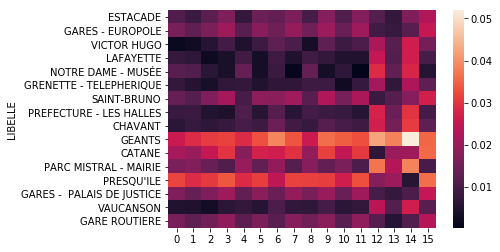

In [30]:
# Sort clusters by descending max distance to the nearest car park
print(df_max_distance.min().sort_values(ascending=False))

# Visualization of min distances from clusters to car parks
heatmap_max = sns.heatmap(df_max_distance)